In [1]:
from __future__ import division
import math
import numpy as np
import torch
from torchvision.models.alexnet import alexnet
from torchvision.models.vgg import vgg16, vgg19
from torchvision.models.resnet import resnet18, resnet50
from torchvision.models.densenet import densenet121
from torchvision.models.inception import Inception3

from models.mobilenet import mobilenet
from models.squeezenet import squeezenet1_0

from torch.autograd import Variable

import matplotlib.pyplot as plt

In [2]:
def get_ivm_patch_coordinates(patch_size_x, patch_size_y, patch_x0, patch_y0, padding_x, padding_y,
                              filter_width, filter_height, stride_x, stride_y,
                              input_width, input_height, output_width, output_height, tau):

    out_x0 = max(math.ceil((patch_x0 + padding_x - filter_width + 1.0)/stride_x), 0)
    out_y0 = max(math.ceil((patch_y0 + padding_y - filter_height + 1.0)/stride_y), 0)
    
    out_width = min(math.ceil((filter_width + patch_size_x - 1.0)/stride_x), output_width)
    out_height = min(math.ceil((filter_height + patch_size_y - 1.0)/stride_y), output_height)
    
    if (out_width > tau*output_width) or (input_width > tau*input_width):
        out_width_t = min(tau*output_width, out_width)
        out_height_t = min(tau*output_height, out_height)
        
        out_x0 = out_x0 - (out_width-out_width_t)//2
        out_y0 = out_y0 - (out_height-out_height_t)//2
        
        out_width, out_height = out_width_t, out_height_t
    
    in_x0 = out_x0 * stride_x - padding_x
    in_y0 = out_y0 * stride_y - padding_y
    
    in_width = filter_width + (out_width-1)*stride_x
    in_height = filter_height + (out_height-1)*stride_y   
    
    return int(in_x0), int(in_x0+in_width), int(in_y0), int(in_y0+in_height), int(out_x0), int(out_x0+out_width), int(out_y0), int(out_y0+out_height)

In [11]:
def calculate_ivm_flops(model, x, patch_size_x, patch_size_y, patch_x0, patch_y0, tau=1.0, debug=True, graph=None):
    if graph is None:
        trace, _ = torch.jit.trace(model, args=(x))
        torch.onnx._optimize_trace(trace)
        graph = trace.graph()

    nodes = list(graph.nodes())
    inputs = list(graph.inputs())

    coordinates = {inputs[0].uniqueName(): (patch_x0, patch_x0 + patch_size_x, patch_y0, patch_y0 + patch_size_y)}

    ops_count = 0
    counter = 0
    for node in nodes:
        if node.kind() in ['onnx::Conv', 'onnx::MaxPool', 'onnx::AveragePool']:
            kernel_height, kernel_width = node['kernel_shape']
            stride_x, stride_y = node['strides']

            if node.kind() == 'onnx::Conv':
                padding_x, _, padding_y, _ = node['pads']
                group = node['group']
            else:
                group = 1
                padding_x, _, padding_y,_ = node['pads']

            inputs = list(node.inputs())
            outputs = list(node.outputs())
            
            patch_x0, patch_x1, patch_y0, patch_y1 = coordinates[inputs[0].uniqueName()]

            _, in_channels, in_height, in_width = inputs[0].type().sizes()
            output_width = ((in_width - kernel_width + 2 * padding_x) // stride_x + 1)
            output_height = ((in_height - kernel_height + 2 * padding_y) // stride_y + 1)

            if node.kind() == 'onnx::Conv':
                out_channels, _, _, _ = inputs[1].type().sizes()

                _, _, _, _, patch_x0, patch_x1, patch_y0, patch_y1 = get_ivm_patch_coordinates(patch_x1 - patch_x0,
                                                                                               patch_y1 - patch_y0,
                                                                                               patch_x0,
                                                                                               patch_y0,
                                                                                               padding_x,
                                                                                               padding_y,
                                                                                               kernel_width,
                                                                                               kernel_height,
                                                                                               stride_x,
                                                                                               stride_y,
                                                                                               in_width,
                                                                                               in_height,
                                                                                               output_width,
                                                                                               output_height,
                                                                                               tau)

                temp = (patch_x1 - patch_x0) * (
                patch_y1 - patch_y0) * out_channels * (kernel_width ** 2) * in_channels / group

                if debug:
                    print (counter, "FLOPS:", node.kind(), temp / (1000 ** 2), (int(output_width), int(output_width)),
                           (patch_x0, patch_x1, patch_y0, patch_y1, int(out_channels)), ((int(kernel_width),
                                                                                                  int(kernel_width)),
                                                                                                 int(in_channels/group)))
                    counter += 1

                ops_count += temp
            else:

                _, _, _, _, patch_x0, patch_x1, patch_y0, patch_y1 = get_ivm_patch_coordinates(patch_x1 - patch_x0,
                                                                                               patch_y1 - patch_y0,
                                                                                               patch_x0,
                                                                                               patch_y0,
                                                                                               padding_x,
                                                                                               padding_y,
                                                                                               kernel_width,
                                                                                               kernel_height,
                                                                                               stride_x,
                                                                                               stride_y,
                                                                                               in_width,
                                                                                               in_height,
                                                                                               output_width,
                                                                                               output_height,
                                                                                               tau)

            coordinates[outputs[0].uniqueName()] = (patch_x0, patch_x1, patch_y0, patch_y1)
            

        elif node.kind() in ['onnx::Gemm']:
            inputs = list(node.inputs())
            outputs = list(node.outputs())
            
            _, in_width = inputs[0].type().sizes()
            out_width, _ = inputs[1].type().sizes()

            temp = in_width * out_width

            if debug:
                print ("FLOPS:", node.kind(), temp / (1000 ** 2))

            ops_count += temp
            coordinates[outputs[0].uniqueName()] = (-1, -1, -1, -1)

        else: # A conv operator comes with a proceeding Select
            # shape preserving operations
            inputs = list(node.inputs())
            outputs = list(node.outputs())
            
            if node.kind() in ['onnx::Concat']:  # DenseNet
                coordinates[outputs[0].uniqueName()] = coordinates[
                    inputs[-1].uniqueName()]  # last input is the most changed one
            elif node.kind() in ['onnx::Relu', 'onnx::BatchNormalization',
                                 'onnx::Dropout', 'onnx::Flatten', 'onnx::Add']:
                coordinates[outputs[0].uniqueName()] = coordinates[inputs[0].uniqueName()]
            else:
                #print(node.kind())
                pass

    return ops_count


def calculate_flops(model, x, debug=True, graph=None):

    if graph is None:
        trace, _ = torch.jit.trace(model, args=(x,))
        torch.onnx._optimize_trace(trace)
        graph = trace.graph()

    nodes = list(graph.nodes())

    ops_count = 0
    counter = 0
    for node in nodes:
        
        if node.kind() in ['onnx::Conv', 'onnx::MaxPool', 'onnx::AveragePool']:
            kernel_width, kernel_height = node['kernel_shape']
            stride_x, stride_y = node['strides']

            if node.kind() == 'onnx::Conv':
                padding_x, _, padding_y, _ = node['pads']
                group = node['group']
            else:
                padding_x, _, padding_y, _ = node['pads']

            inputs = list(node.inputs())

            if node.kind() == 'onnx::Conv':
                _, in_channels, in_x, in_y = inputs[0].type().sizes()
                out_channels, _, _, _ = inputs[1].type().sizes()

                output_width = ((in_x - kernel_width + 2 * padding_x) // stride_x + 1)
                output_height = ((in_y - kernel_height + 2 * padding_y) // stride_y + 1)
                temp = (output_width * output_height) * out_channels * (kernel_width * kernel_height) * in_channels / group

                if debug:
                    print (counter, "FLOPS:", node.kind(), out_channels, temp / (1000 ** 2))
                    counter += 1

                ops_count += temp

        elif node.kind() in ['onnx::Gemm']:
            inputs = list(node.inputs())
            _, in_width = inputs[0].type().sizes()
            out_width, _ = inputs[1].type().sizes()

            temp = in_width * out_width

            if debug:
                print (counter, "FLOPS:", node.kind(), temp / (1000 ** 2))
                counter += 1
                
            ops_count += temp

    return ops_count

### Redundency ratios calculation

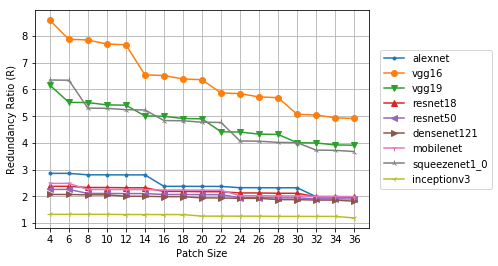

In [14]:
x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 224, 224), dtype=np.float32)))
models = [alexnet(), vgg16(), vgg19(), resnet18(), resnet50(), densenet121(), mobilenet(), squeezenet1_0()]


patch_sizes = [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]

markers = [".","o","v","^","<",">","1","2"]
for name, model, m in zip(['alexnet', 'vgg16', 'vgg19', 'resnet18', 'resnet50', 'densenet121', 'mobilenet',
                       'squeezenet1_0'], models, markers):

    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
  
    r = []
    for patch_size in patch_sizes:
        
        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)
        
    plt.plot(patch_sizes, r, label=name, marker=m)
    
    
x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 299, 299), dtype=np.float32)))
models = [Inception3()]
markers = ["3"]
for name, model, m in zip(['inceptionv3'], models, markers):

    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()

    r = []
    for patch_size in patch_sizes:
        
        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (299-patch_size)//2
        j = (299-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)
        
    plt.plot(patch_sizes, r, label=name, marker=m)

lgd = plt.legend(loc='center right', bbox_to_anchor=(1.38, 0.5), ncol=1)
plt.grid()
plt.ylabel('Redundancy Ratio (R)')
plt.xlabel('Patch Size')
plt.xticks(patch_sizes, patch_sizes)

plt.savefig('../images/redundancy_ratio.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Thresholding Redundency ratios

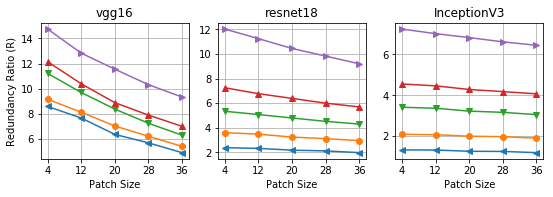

In [65]:
x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 224, 224), dtype=np.float32)))
patch_sizes = [4, 12, 20, 28, 36]
taus = [1.0, 0.8, 0.6, 0.5, 0.4]

markers = ['<', 'o', 'v', '^', '>']


plt.figure(figsize=(9,2.5))

ax = plt.subplot(1, 3, 1)
model = vgg16()
for tau,m in zip(taus, markers):
    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
    
    r = []
    for patch_size in patch_sizes:

        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph, tau=tau) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)

    plt.plot(patch_sizes, r, label=r'$\tau = $' + str(tau), marker=m)

ax.set_title('vgg16')
plt.grid()
plt.ylabel('Redundancy Ratio (R)')
plt.xlabel('Patch Size')
plt.xticks(patch_sizes, patch_sizes)


ax = plt.subplot(1, 3, 2)
model = resnet18()
for tau,m in zip(taus, markers):
    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
    
    r = []
    for patch_size in patch_sizes:

        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph, tau=tau) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)

    plt.plot(patch_sizes, r, label=r'$\tau = $' + str(tau), marker=m)

ax.set_title('resnet18')    
plt.grid()
plt.xlabel('Patch Size')
plt.xticks(patch_sizes, patch_sizes)

    
x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 299, 299), dtype=np.float32)))    
ax = plt.subplot(1, 3, 3)
model = Inception3()
for tau,m in zip(taus, markers):
    with torch.onnx.set_training(model, False):
        trace, _ = torch.jit.get_trace_graph(model, args=(x,))
        
    torch.onnx._optimize_trace(trace, False)
    graph = trace.graph()
    
    r = []
    for patch_size in patch_sizes:

        full_flops = calculate_flops(model, x, debug=False, graph=graph) / (1000 ** 2)
        i = (224-patch_size)//2
        j = (224-patch_size)//2
        ivm_flops = calculate_ivm_flops(model, x, patch_size, patch_size, i, j, debug=False, graph=graph, tau=tau) / (1000 ** 2)

        #print(name, patch_size, full_flops, ivm_flops, full_flops/ivm_flops)
        r.append(full_flops/ivm_flops)

    plt.plot(patch_sizes, r, label=r'$\tau = $' + str(tau), marker=m)
    
ax.set_title('InceptionV3')
plt.grid()
plt.xlabel('Patch Size')
plt.xticks(patch_sizes, patch_sizes)    
        
#lgd = plt.legend(loc='lower center', bbox_to_anchor=(-0.7, -0.47), ncol=4)
plt.savefig('../images/th_redundancy_ratio.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
from models.flops_benchmark import add_flops_counting_methods

model = Inception3()
model = model.eval()
model = add_flops_counting_methods(model)
model.start_flops_count()

x = Variable(torch.from_numpy(np.zeros(shape=(1, 3, 299, 299), dtype=np.float32)))
model(x)
print(model.compute_average_flops_cost() / 1e9 / 2)